In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pylab import rcParams
from tqdm import tqdm
import pickle
rcParams['figure.figsize'] = (22,5)

In [12]:
FILE_PATH = "../dataset/excel_fpt.csv"
START_YEAR = 2016
VALIDATION_SIZE = 100
TEST_SIZE = 30
TEST_HORIZON = 7
SEASONALITY = False

In [13]:
def MAPE_point(true_value, predict_value):
    return 100 * np.abs((true_value - predict_value)/true_value)

def MAPE_range(true_values, predict_values):
    percen_errors = []
    for i in range(len(true_values)):
        percen_errors.append(100 * np.abs((true_values[i] - predict_values[i])/true_values[i]))
    return sum(percen_errors)/len(percen_errors)

In [14]:
df = pd.read_csv(FILE_PATH)
df.head()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,FPT,20201216,57.2,57.5,57.0,57.1,1995530
1,FPT,20201215,57.5,57.6,56.6,56.7,2666900
2,FPT,20201214,57.0,58.0,56.9,57.2,1443760
3,FPT,20201211,56.6,57.0,56.3,57.0,1750270
4,FPT,20201210,57.0,57.7,56.5,56.5,2112490


In [15]:
columns = df.columns
columns_remove_bracket = [label.replace("<","").replace(">","") for label in columns]
columns_to_replace = {columns[i]: columns_remove_bracket[i] for i in range(len(df.columns))}
df.rename(columns=columns_to_replace, inplace=True)
df.drop(["Ticker","Open","High","Low","Volume"], axis=1, inplace=True)
df["DTYYYYMMDD"] = pd.to_datetime(df["DTYYYYMMDD"], format="%Y%m%d", errors="coerce")
df.rename(columns={"DTYYYYMMDD": "ds", "Close": "y"}, inplace=True)
df = df[df["ds"].dt.year >= START_YEAR]
df.sort_values(by="ds", inplace=True, ascending=True)
df.reset_index(inplace=True, drop=True)
df.head()

,ds,y
0,2016-01-04,20.0549
1,2016-01-05,20.0549
2,2016-01-06,20.0968
3,2016-01-07,19.7192
4,2016-01-08,19.4255


In [16]:
df.tail()

,ds,y
1235,2020-12-10,56.5
1236,2020-12-11,57.0
1237,2020-12-14,57.2
1238,2020-12-15,56.7
1239,2020-12-16,57.1


<AxesSubplot:title={'center':'Giá cổ phiếu FPT từ năm 2016 đến năm 2020'}, xlabel='ds', ylabel='ĐV: Nghìn VNĐ'>

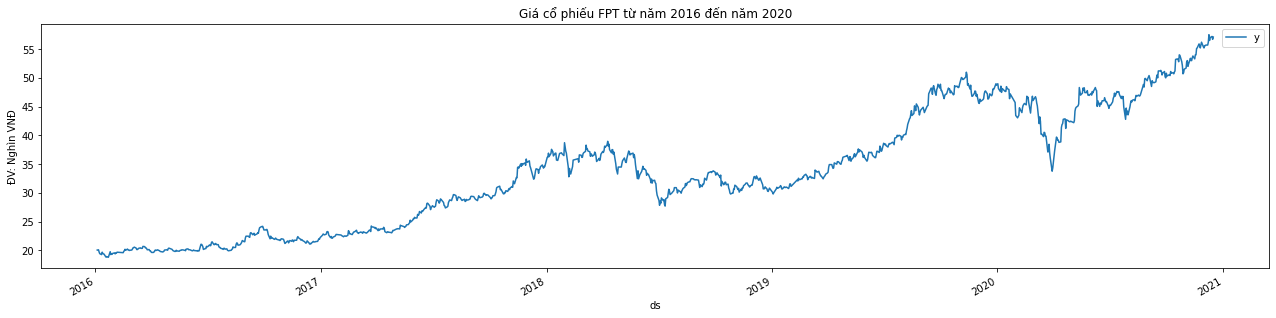

In [17]:
df_copy = df.copy()
df_copy.set_index("ds", inplace=True)
df_copy.plot(title=f"Giá cổ phiếu FPT từ năm {START_YEAR} đến năm 2020", ylabel="ĐV: Nghìn VNĐ")

In [18]:
total = len(df)
x_train, x_valid = df[:total-VALIDATION_SIZE-TEST_SIZE], df[total-VALIDATION_SIZE-TEST_SIZE:total-TEST_SIZE]
x_test = df[total-TEST_SIZE:]
total, x_train.shape, x_valid.shape, x_test.shape
x_test.tail()

,ds,y
1235,2020-12-10,56.5
1236,2020-12-11,57.0
1237,2020-12-14,57.2
1238,2020-12-15,56.7
1239,2020-12-16,57.1


model = Prophet(daily_seasonality=False, n_changepoints=100, changepoint_prior_scale=0.5, changepoint_range=0.99)
model.fit(x_train)

In [19]:
# df_future = model.make_future_dataframe(periods=len(x_test), include_history=False)
df_future_valid = x_valid.drop(columns=["y"])
df_future_test = x_test.drop(columns=["y"])
df_future_valid.reset_index(inplace=True, drop=True)
df_future_test.reset_index(inplace=True, drop=True)
df_future_valid.head()

,ds
0,2020-06-17
1,2020-06-18
2,2020-06-19
3,2020-06-22
4,2020-06-23


forecast = model.predict(df_future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

figure_1 = model.plot(forecast)
x_test_clone = x_test.copy()
x_test_clone.set_index("ds", inplace=True)
plt.plot(x_test_clone, color="red", label="True values")
plt.legend()

figure_2 = model.plot_components(forecast)

forecast.head()

$\overline y$ = trend + weekly + yearly (không cộng cho additive terms)

x_test.head()

forecast[["ds", "yhat"]].head()

## Metrics

Compute the **mean absolute percentage error (MAPE)** over all predictions

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}\left|\frac{actual_t - predicted_t}{actual_t}\right|$$

true_values = x_test["y"].values
true_values.shape

predict_values = forecast["yhat"].values
predict_values.shape

MAPE_point(true_values[0], predict_values[0])

MAPE_range(true_values, predict_values)

## Rolling leanring

In [20]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

## Validate and turning hyperparameters

In [33]:
changepoint_ranges = np.logspace(np.log10(0.8), np.log10(0.99), num=5)
changepoint_prior_scales = np.logspace(np.log10(0.05), np.log10(0.8), num=5)
seasonality_prior_scales = np.logspace(np.log10(0.01), np.log10(10), num=5)

In [40]:
turn_params = []
model = None
for cp_range in changepoint_ranges:
    for cp_prior_scale in changepoint_prior_scales:
        for sea_prior_scale in seasonality_prior_scales:
            
            print(f"Current Params: \nchangepoint_range: {cp_range}, changepoint_prior_scale: {cp_prior_scale}, season_prior_scale: {sea_prior_scale}")
            x_train_gridSearch = x_train.copy()
            y_trues, y_preds = [], []
            params = {
                "changepoint_range": cp_range,
                "changepoint_prior_scale": cp_prior_scale,
                "seasonality_prior_scale": sea_prior_scale
            }
            
            model = Prophet(**params).fit(x_train_gridSearch)
            y_trues.extend(x_valid["y"].values)
            future_need_predict = df_future_valid.copy()
            predict_df = model.predict(future_need_predict)
            y_preds.extend(predict_df['yhat'].values)
                
            current_MAPE = MAPE_range(y_trues, y_preds)
            print("Current MAPE:", current_MAPE)
            
            turn_params.append({
                "MAPE": current_MAPE, 
                "changepoint_range": cp_range,
                "changepoint_prior_scale": cp_prior_scale,
                "seasonality_prior_scale": sea_prior_scale
            })
            
                

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.241585575973535
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.221884338975108
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.210428216780364
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.2049802366537987
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.194877248546588
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.1, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 5.294864010237364
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.1, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 6.787085997649485
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.1, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 6.776921232207549
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.1, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 6.730050650694944
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.1, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 6.82915089653916
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.307776342396169
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 10.702751642107817
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 11.264577678488076
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 10.987166107735463
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 11.061573490425362
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 10.69075052988538
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 17.1737096941371
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 16.9795604696846
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 16.421422678964493
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 16.000870280066422
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.8, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 11.582572714886167
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.8, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 18.04174693407746
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.8, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 18.835702428685668
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.8, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 18.40516435440635
Current Params: 
changepoint_range: 0.8, changepoint_prior_scale: 0.8, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 18.614569762784555
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.649585535890992
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.471827048686507
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.386844182303241
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.394742155794944
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.441260063760133
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.1, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 7.573274128196785
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.1, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 6.210433008038299
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.1, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 4.148706389741998
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.1, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 6.788522149903087
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.1, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 5.614025804427024
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 3.477972531700414
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 6.529762805741569
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 7.257481873545681
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 7.263955518780208
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 7.485605557806918
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 4.951640284795697
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 11.591533069253149
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 11.660907583078037
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 11.758977857103845
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 12.097550615911018
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.8, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 4.623074592975498
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.8, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 14.624625820038448
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.8, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 14.049280454020455
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.8, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 14.033287009775743
Current Params: 
changepoint_range: 0.8437742913606598, changepoint_prior_scale: 0.8, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 14.227088039340321
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.939863943693005
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.558654911171097
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.719427934626548
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.73062217518074
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.746478368521416
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.1, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.723835437930203
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.1, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.454867694353657
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.1, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.46334729923335
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.1, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.509285516978624
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.1, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.515315486124246
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 3.715353071800244
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.72905494360751
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.9018300123897065
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.840642141307523
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.7831440159218404
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 3.863657594590349
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.030621408981219
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.604099196479867
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.640903586493334
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.297942950343364
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.8, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 6.251467666385754
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.8, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 14.676738959060613
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.8, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 16.037562772334212
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.8, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 14.59799587555456
Current Params: 
changepoint_range: 0.8899438184514796, changepoint_prior_scale: 0.8, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 13.663722208754596
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.949960850694057
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 3.128480348771155
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.735344247435663
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 3.0063939282505086
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.824552144706565
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.1, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 3.8630957023114054
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.1, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 3.998946878634444
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.1, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 4.2056036802286885
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.1, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 4.092116235402495
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.1, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 4.0915590637467725
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 6.349499128900044
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 7.932932566308125
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 7.3524227486842015
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 7.766132974811163
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 7.503380582754869
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.48130826244164
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 12.155159565842398
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 11.216293495933698
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 12.396879517551042
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 12.291984425299418
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.8, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 9.129006242114313
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.8, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 14.545750231270453
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.8, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 14.160774663768807
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.8, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 14.733640231189348
Current Params: 
changepoint_range: 0.938639643455871, changepoint_prior_scale: 0.8, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 13.11802277098448
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 7.450335453877805
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.244910866599058
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 7.430149628193851
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.524411522186492
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.049999999999999996, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.838879255771829
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.1, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 16.261077637756465
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.1, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 16.12340553005838
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.1, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 16.15821324017287
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.1, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 17.001973467606852
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.1, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 15.982204942395997
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 18.725019631397288
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 19.037746693625166
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 19.50440359094205
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 18.985230879174132
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.19999999999999998, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 19.669307542066086
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 10.88684937432424
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 10.674306189656074
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 10.77456206438456
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 11.018986337768458
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.3999999999999999, season_prior_scale: 10.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 8.422986705292079
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.8, season_prior_scale: 0.01


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 3.0342539455926727
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.8, season_prior_scale: 0.05623413251903491


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.9796692497211694
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.8, season_prior_scale: 0.31622776601683794


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.795153726752953
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.8, season_prior_scale: 1.7782794100389228


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current MAPE: 2.589036722375271
Current Params: 
changepoint_range: 0.99, changepoint_prior_scale: 0.8, season_prior_scale: 10.0
Current MAPE: 2.4439448292575783


## Testing model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE of final model: 2.4515605813398578


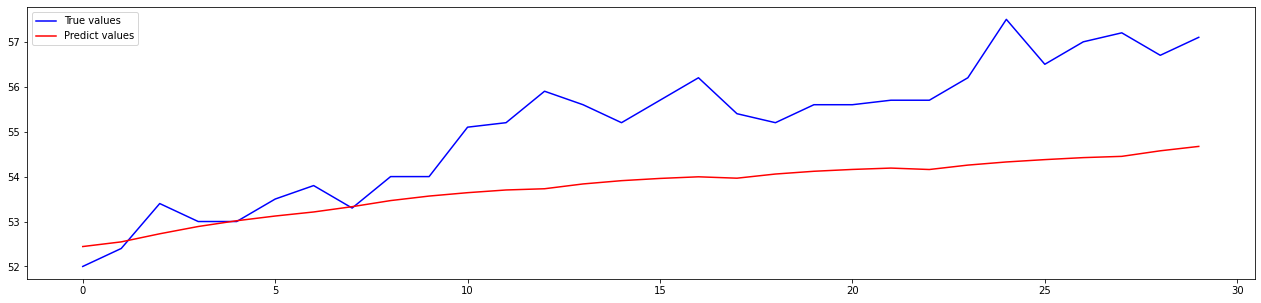

Best Parameters: {'changepoint_range': 0.99, 'changepoint_prior_scale': 0.19999999999999998, 'seasonality_prior_scale': 10.0}


In [62]:
y_trues, y_preds = [], []

# select best params here...
best_params = sorted(turn_params, key=lambda item: item["MAPE"])[-1]

params = {
    "changepoint_range": float(best_params["changepoint_range"]),
    "changepoint_prior_scale": float(best_params["changepoint_prior_scale"]),
    "seasonality_prior_scale": float(best_params["seasonality_prior_scale"])
}

x_train_clone = x_train.copy()
x_train_clone = x_train_clone.append(x_valid, ignore_index = True)

model_final = Prophet(**params).fit(x_train_clone)   
y_trues.extend(x_test["y"].values)
future_need_predict = df_future_test.copy()
predict_df = model_final.predict(future_need_predict)
y_preds.extend(predict_df['yhat'].values)

print("MAPE of final model:", MAPE_range(y_trues, y_preds))

plt.plot(np.arange(len(y_trues)), y_trues, color="blue", label="True values")
plt.plot(np.arange(len(y_preds)), y_preds, color="red", label="Predict values")
plt.legend()
plt.savefig("Prophet predict 30 days.png")
plt.show()

print("Best Parameters:", params)

In [22]:
best_params = {
    'changepoint_range': 0.99, 
    'changepoint_prior_scale': 0.19999999999999998, 
    'seasonality_prior_scale': 10.0
}

params = {
    "changepoint_range": float(best_params["changepoint_range"]),
    "changepoint_prior_scale": float(best_params["changepoint_prior_scale"]),
    "seasonality_prior_scale": float(best_params["seasonality_prior_scale"])
}

x_train_clone = x_train.copy()
x_train_clone = x_train_clone.append(x_valid, ignore_index = True)
x_train_clone = x_train_clone.append(x_test, ignore_index = True)
model_final = Prophet(**params).fit(x_train_clone)   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
with open("ProphetModel.txt", "wb") as f:
  pickle.dump(model_final, f)

# with open("ProphetModel.txt", "rb") as f:
#     fresh_model = pickle.load(f)
#     fresh_predict = fresh_model.predict(future_need_predict)
#     print(fresh_predict["yhat"].values)

In [49]:
# Chỉ sử dụng khi không turn mô hình:
best_params_after_turn = {'changepoint_range': 0.99, 'changepoint_prior_scale': 0.19999999999999998, 'seasonality_prior_scale': 10.0}
y_trues, y_preds = [], []

params = {
    "changepoint_range": float(best_params_after_turn["changepoint_range"]),
    "changepoint_prior_scale": float(best_params_after_turn["changepoint_prior_scale"]),
    "seasonality_prior_scale": float(best_params_after_turn["seasonality_prior_scale"])
}

x_train_clone = x_train.copy()
x_train_clone = x_train_clone.append(x_valid, ignore_index = True)

model_final = Prophet(**params).fit(x_train_clone)   
y_trues.extend(x_test["y"].values)
future_need_predict = df_future_test.copy()
predict_df = model_final.predict(future_need_predict)
y_preds.extend(predict_df['yhat'].values)

print("MAPE of final model:", MAPE_range(y_trues, y_preds))

plt.plot(np.arange(len(y_trues)), y_trues, color="blue", label="True values")
plt.plot(np.arange(len(y_preds)), y_preds, color="red", label="Predict values")
plt.legend()
plt.show()
plt.savefig("Prophet predict 30 days.png")

-1.9661128563728327

In [85]:
predict_dict = []
for i in range(len(predict_df)):
    predict_dict.append({"value": predict_df.loc[i, "yhat"], "time": predict_df.loc[i, "ds"].strftime("%m/%d/%Y, %H:%M:%S")})
print(predict_dict)

[{'value': 52.44295341314201, 'time': '11/05/2020, 00:00:00'}, {'value': 52.54687438772051, 'time': '11/06/2020, 00:00:00'}, {'value': 52.726994793837186, 'time': '11/09/2020, 00:00:00'}, {'value': 52.88894572535741, 'time': '11/10/2020, 00:00:00'}, {'value': 53.017416498951455, 'time': '11/11/2020, 00:00:00'}, {'value': 53.12226959927759, 'time': '11/12/2020, 00:00:00'}, {'value': 53.21256541371406, 'time': '11/13/2020, 00:00:00'}, {'value': 53.3303914183466, 'time': '11/16/2020, 00:00:00'}, {'value': 53.466126001832244, 'time': '11/17/2020, 00:00:00'}, {'value': 53.56653654573337, 'time': '11/18/2020, 00:00:00'}, {'value': 53.64201455405966, 'time': '11/19/2020, 00:00:00'}, {'value': 53.70213572292777, 'time': '11/20/2020, 00:00:00'}, {'value': 53.729424236831676, 'time': '11/23/2020, 00:00:00'}, {'value': 53.83640494043638, 'time': '11/24/2020, 00:00:00'}, {'value': 53.90939271480176, 'time': '11/25/2020, 00:00:00'}, {'value': 53.959087935335, 'time': '11/26/2020, 00:00:00'}, {'valu

In [1]:
a = [{"value": 10, "time": "10/2/3 3:2:2"}]
str(a)

"[{'value': 10, 'time': '10/2/3 3:2:2'}]"

In [21]:
import vnquant.DataLoader as web
loader = web.DataLoader('FPT', '2018-02-02','2020-12-27')
data = loader.download()
data.tail()

C:\Users\manvd1\Anaconda3\envs\learningspace\lib\site-packages\vnquant-0.0.2-py3.7.egg\vnquant\DataLoader.py:210: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  stock_data['change_perc1'], stock_data['change_perc2'] = stock_data.change_perc.apply(utils.split_change_col).str
2020-12-27 17:34:41,178 : INFO : data FPT from 2018-02-02 to 2020-12-27 have already cloned!


Attributes,high,low,open,close,adjust,volume
Symbols,FPT,FPT,FPT,FPT,FPT,FPT
date,,,,,,
2020-12-21,57.8,57.1,57.3,57.5,57.5,2361390
2020-12-22,58.5,57.1,57.4,58.1,58.1,2576390
2020-12-23,58.6,57.2,58.3,57.5,57.5,2941420
2020-12-24,57.8,56.4,57.5,57.0,57.0,2386210
2020-12-25,57.6,56.6,57.0,57.6,57.6,1625110


In [22]:
data.columns = ["high", "low", "open", "close", "adjust", "volume"]

In [23]:
data.reset_index(drop=False, inplace=True)

In [25]:
data.tail()

,date,high,low,open,close,adjust,volume
719,2020-12-21,57.8,57.1,57.3,57.5,57.5,2361390
720,2020-12-22,58.5,57.1,57.4,58.1,58.1,2576390
721,2020-12-23,58.6,57.2,58.3,57.5,57.5,2941420
722,2020-12-24,57.8,56.4,57.5,57.0,57.0,2386210
723,2020-12-25,57.6,56.6,57.0,57.6,57.6,1625110
